<a href="https://colab.research.google.com/github/Dolewma/retail_demand_forecast/blob/main/course_project_week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data//transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')


In [8]:
# Select list of stores located in the 'Pichincha' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/train.csv', chunksize=chunk_size, low_memory=False):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# select only 2 000 000 random rows and resetting the index
df_train = df_train.sample(n=2000000)
df_train = df_train.reset_index(drop=True)

# Clean up to free memory
del filtered_chunks

In [9]:
# Assuming that you have items.csv file read in into a variable called df_items
# we first get the top-3 families by the number of items
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # here is where we get the top-3 families

# Next, we filter our the dataset
# Assuming that train.csv file was read into a variable called df_train
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

# As a result, you'll have the df_train that only has items from the top 3 families
# this is exactly what we need

In [15]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64


In [12]:
# Fill missing values in onpromotion column with False
df_train['onpromotion'] = df_train['onpromotion'].fillna(False)

/tmp/ipython-input-12-3643636192.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False)


In [13]:
# Check for missing values
df_train.isnull().sum()
print("Missing values per column:\n")

Missing values per column:



In [16]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1710,46045010,2015-05-04,29,1114566,-7.0,False
114368,114988461,2017-05-08,24,1047699,-1.0,False
132570,109297328,2017-03-15,32,1991217,-10.0,False
134514,44296912,2015-04-06,24,119191,-3.0,False
137134,71229802,2016-02-21,36,1137146,-4.0,False


In [17]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

# Print summary
print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3438


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
297,13913614,2013-11-13,24,105575,115.0,False,9.009431
737,37497335,2014-12-16,24,105857,30.0,False,6.919746
1531,15510396,2013-12-15,24,111397,62.0,False,5.121633
1786,96098549,2016-11-06,24,114790,37.0,True,5.452140
1875,95994239,2016-11-05,24,114790,37.0,True,5.452140


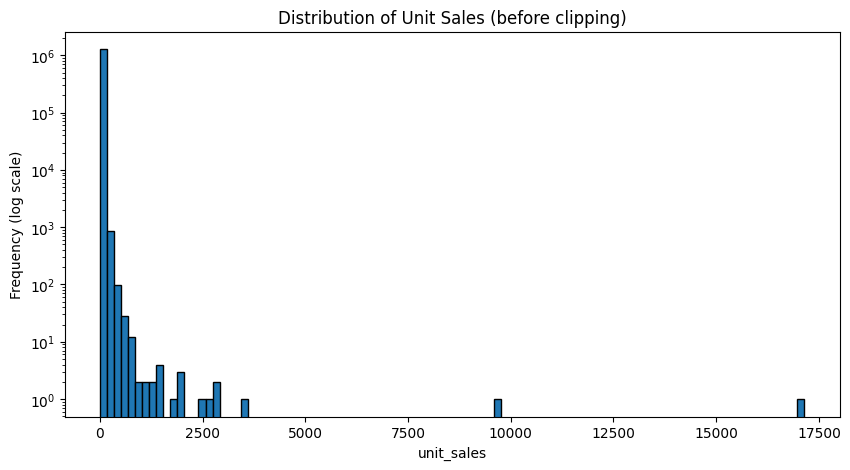

In [18]:
# Outliers in unit_sales
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df_train['unit_sales'], bins=100, edgecolor='k')
plt.yscale('log')  # Log-Skala hilft Ausreißer zu erkennen
plt.title('Distribution of Unit Sales (before clipping)')
plt.xlabel('unit_sales')
plt.ylabel('Frequency (log scale)')
plt.show()

In [19]:
# Datum konvertieren
df_train['date'] = pd.to_datetime(df_train['date'])

# Funktion zum Auffüllen fehlender Tage
def fill_calendar(group):
    g = group.set_index("date").sort_index()
    g = g.asfreq("D", fill_value=0)  # macht es zu einer täglichen Zeitreihe
    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"] = group["item_nbr"].iloc[0]
    return g.reset_index()

# Anwendung auf jedes (store_nbr, item_nbr) Paar
df_filled = (
    df_train
    .groupby(["store_nbr", "item_nbr"], group_keys=False)
    .apply(fill_calendar)
)


In [20]:
# Zeitbezogene Features extrahieren
df_filled['year'] = df_filled['date'].dt.year
df_filled['month'] = df_filled['date'].dt.month
df_filled['day'] = df_filled['date'].dt.day
df_filled['day_of_week'] = df_filled['date'].dt.dayofweek  # Mo = 0


In [21]:
# 7-Tage Gleitmittelwert der Verkäufe
df_filled['unit_sales_7d_avg'] = (
    df_filled
    .groupby(['item_nbr', 'store_nbr'])['unit_sales']
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)


In [22]:
# Daten speichern auf Google Drive
df_filled.to_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/df_prepared_guayas.csv', index=False)


In [41]:
df_filled.isnull().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
year,0
month,0
day,0
day_of_week,0


In [37]:
df_filled.describe(include='all')


,date,id,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
count,22287469,2.228747e+07,2.228747e+07,2.228747e+07,2.228747e+07,22287469,2.228747e+07,2.228747e+07,2.228747e+07,2.228747e+07,2.228747e+07
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,22228353,NaN,NaN,NaN,NaN,NaN
mean,2015-08-25 04:16:28.137608192,3.549629e+06,3.218899e+01,9.114340e+05,3.923302e-01,NaN,2.015166e+03,6.308877e+00,1.571906e+01,3.000258e+00,3.961232e-01
min,2013-01-02 00:00:00,0.000000e+00,2.400000e+01,9.699500e+04,0.000000e+00,NaN,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2014-08-26 00:00:00,0.000000e+00,2.700000e+01,4.545960e+05,0.000000e+00,NaN,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00
50%,2015-10-23 00:00:00,0.000000e+00,3.000000e+01,9.118710e+05,0.000000e+00,NaN,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00,0.000000e+00
75%,2016-09-18 00:00:00,0.000000e+00,3.500000e+01,1.243816e+06,0.000000e+00,NaN,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00,2.857143e-01
max,2017-08-15 00:00:00,1.254915e+08,5.100000e+01,2.127114e+06,1.714600e+04,NaN,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.450857e+03


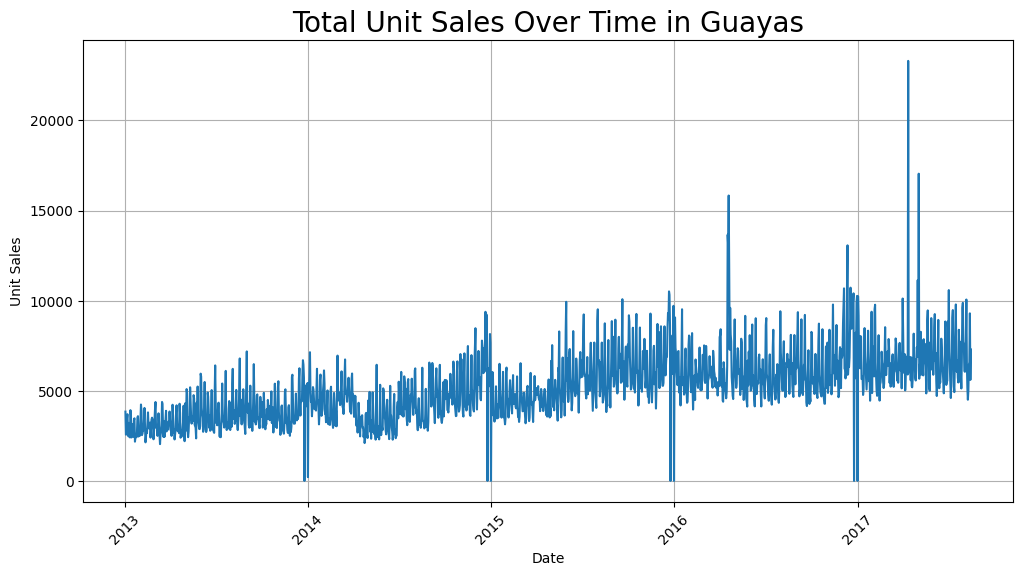

In [23]:
sales_by_date = df_filled.groupby('date')['unit_sales'].sum()

plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()


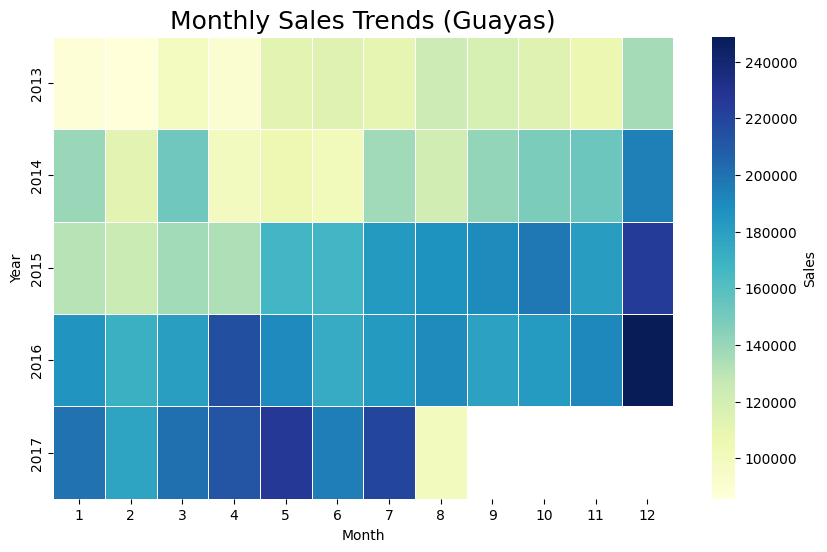

In [25]:
import seaborn as sns
monthly_sales = df_filled.groupby(['year', 'month'])['unit_sales'].sum().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(monthly_sales, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Sales'})
plt.title("Monthly Sales Trends (Guayas)", fontsize=18)
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


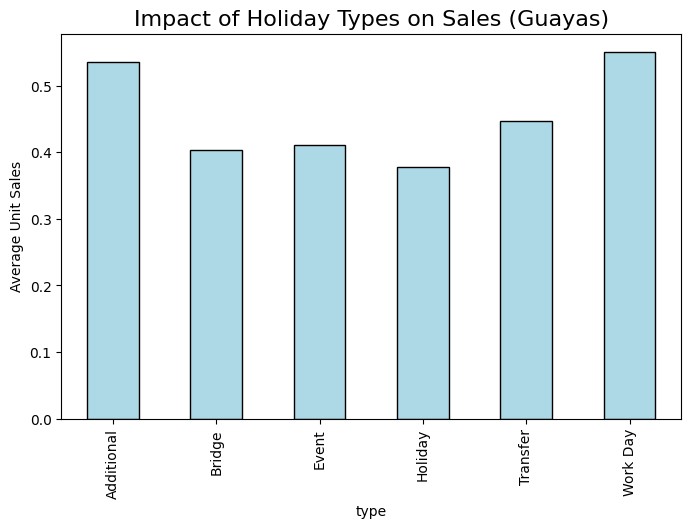

In [26]:
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

# Merge mit Feiertagsdaten
df_holiday_merge = pd.merge(df_filled, df_holidays_events, on='date', how='left')

# Durchschnittsverkäufe je Ereignistyp
holiday_sales = df_holiday_merge.groupby('type')['unit_sales'].mean()

# Balkendiagramm
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Impact of Holiday Types on Sales (Guayas)", fontsize=16)
plt.ylabel("Average Unit Sales")
plt.show()


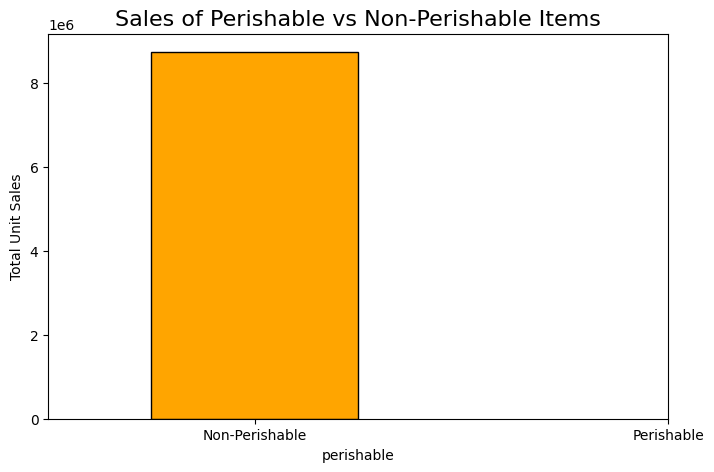

In [30]:
# Merge der perishable-Info
df_perishable = pd.merge(df_filled, df_items[['item_nbr', 'perishable']], on='item_nbr', how='left')

# Explizit fehlende Werte behandeln – sicherheitshalber mit 0 füllen
df_perishable['perishable'] = df_perishable['perishable'].fillna(0).astype(bool)

# Gruppieren und Plotten
sales_by_perish = df_perishable.groupby('perishable')['unit_sales'].sum()

plt.figure(figsize=(8,5))
sales_by_perish.plot(kind='bar', color=['orange', 'green'], edgecolor='black')
plt.title("Sales of Perishable vs Non-Perishable Items", fontsize=16)
plt.xticks(ticks=[0,1], labels=["Non-Perishable", "Perishable"], rotation=0)
plt.ylabel("Total Unit Sales")
plt.show()

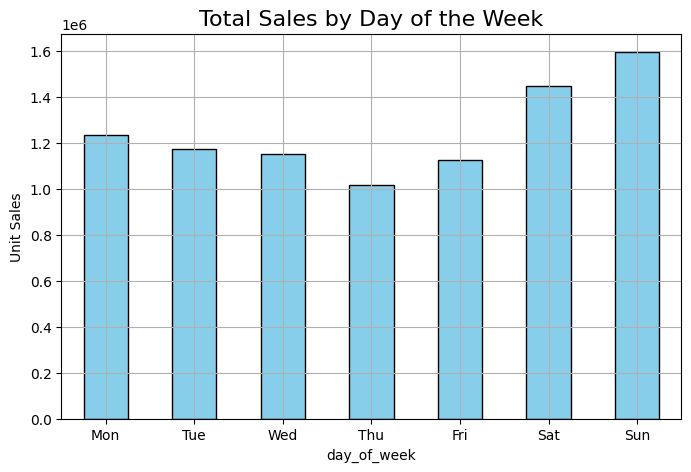

In [38]:
weekday_sales = df_filled.groupby('day_of_week')['unit_sales'].sum()

plt.figure(figsize=(8,5))
weekday_sales.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Total Sales by Day of the Week", fontsize=16)
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.ylabel("Unit Sales")
plt.grid()
plt.show()


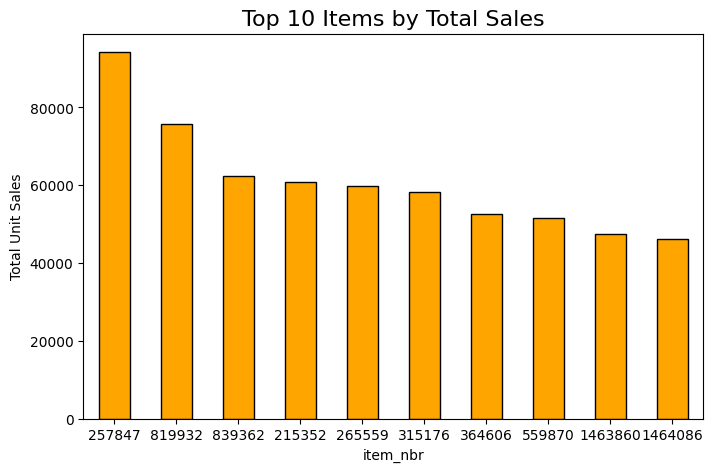

In [47]:
top_items = df_filled.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_items.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 10 Items by Total Sales", fontsize=16)
plt.ylabel("Total Unit Sales")
plt.xticks(rotation=0)
plt.show()


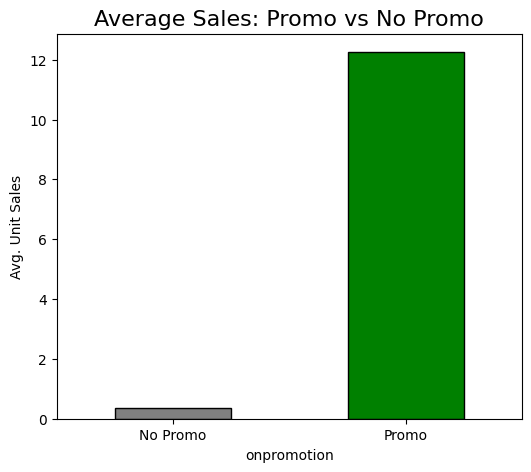

In [42]:
promo_sales = df_filled.groupby('onpromotion')['unit_sales'].mean()

plt.figure(figsize=(6,5))
promo_sales.plot(kind='bar', color=['gray', 'green'], edgecolor='black')
plt.title("Average Sales: Promo vs No Promo", fontsize=16)
plt.xticks(ticks=[0,1], labels=['No Promo', 'Promo'], rotation=0)
plt.ylabel("Avg. Unit Sales")
plt.show()


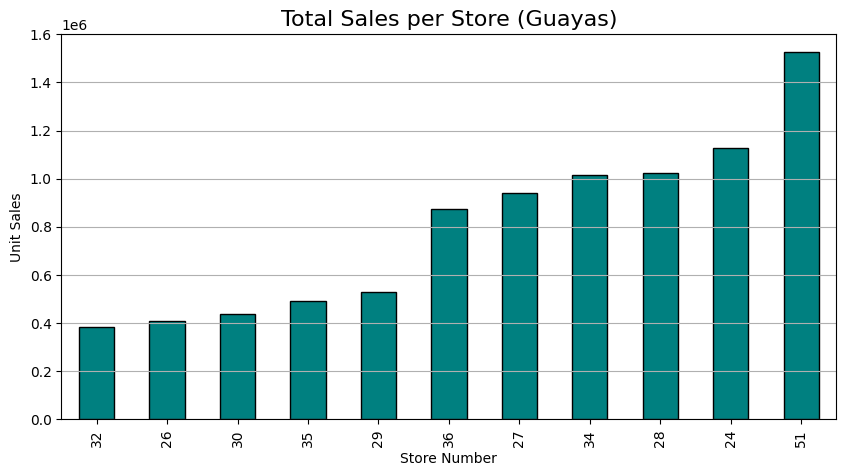

In [43]:
store_sales = df_filled.groupby('store_nbr')['unit_sales'].sum().sort_values()

plt.figure(figsize=(10,5))
store_sales.plot(kind='bar', color='teal', edgecolor='black')
plt.title("Total Sales per Store (Guayas)", fontsize=16)
plt.ylabel("Unit Sales")
plt.xlabel("Store Number")
plt.grid(axis='y')
plt.show()


In [49]:
# Finde die aktivsten Store-Item-Kombinationen
top_combos = (
    df_filled.groupby(['store_nbr', 'item_nbr'])['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

print(top_combos)


store_nbr  item_nbr
51         257847      32158.0
24         257847      23461.0
32         1963892     17788.0
34         819932      17367.0
51         315176      16774.0
Name: unit_sales, dtype: float64


In [57]:
#Stores mit dem höchsten Gesamtumsatz
store_ranking = (
    df_filled.groupby('store_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
)

top_stores = store_ranking.index.tolist()

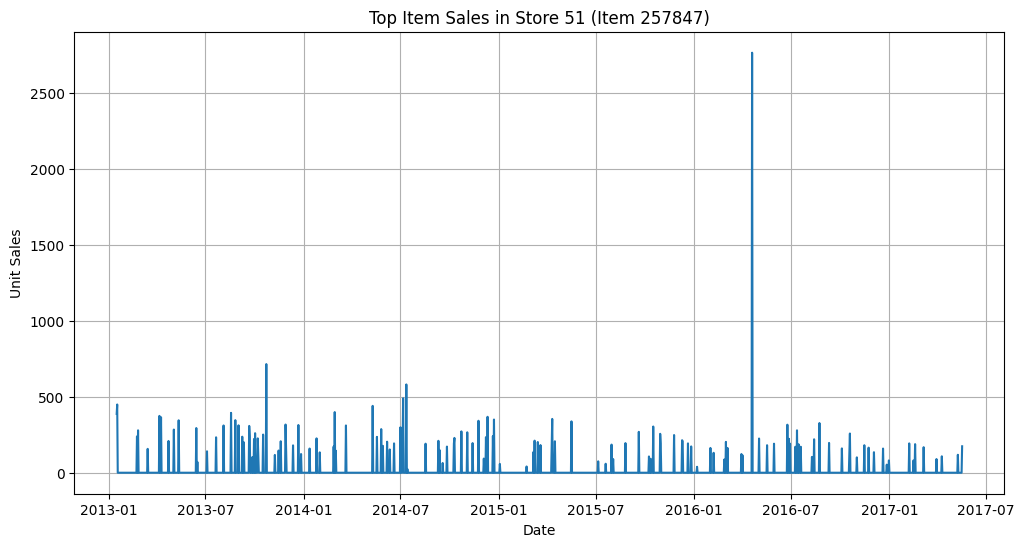

In [60]:
# 🔍 1. Bester Store: meistverkauftes Item
store_id = top_stores[0]
top_item = (
    df_filled[df_filled['store_nbr'] == store_id]
    .groupby('item_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

sample = df_filled[(df_filled['store_nbr'] == store_id) & (df_filled['item_nbr'] == top_item)]

plt.figure(figsize=(12,6))
plt.plot(sample['date'], sample['unit_sales'])
plt.title(f"Top Item Sales in Store {store_id} (Item {top_item})")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.grid()
plt.show()

In [63]:
# Filter auf die Kombination
spike_data = df_filled[(df_filled['store_nbr'] == 51) & (df_filled['item_nbr'] == 257847)]

# Datum mit maximalem Umsatz
max_row = spike_data.loc[spike_data['unit_sales'].idxmax()]
print(max_row[['date', 'unit_sales', 'onpromotion']])


date           2016-04-19 00:00:00
unit_sales                  2764.0
onpromotion                  False
Name: 1189, dtype: object


In [64]:
# Datum extrahieren
peak_date = max_row['date']

# Feiertagsdaten konvertieren und prüfen
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
holiday_info = df_holidays_events[df_holidays_events['date'] == peak_date]

print(holiday_info)


          date   type    locale locale_name         description  transferred
222 2016-04-19  Event  National     Ecuador  Terremoto Manabi+3        False


In [65]:
# Produktdetails zur Item-ID 257847 abrufen
product_info = df_items[df_items['item_nbr'] == 257847]
print(product_info)


     item_nbr     family  class  perishable
207    257847  BEVERAGES   1120           0


In [66]:
# Earthquake on 16.04.2016 in Ecuador, could explain spike
if '2016-04-16' <= str(peak_date) <= '2016-05-15':
    print("⚠️ Möglicher Einfluss des Erdbebens auf die Verkäufe.")


⚠️ Möglicher Einfluss des Erdbebens auf die Verkäufe.


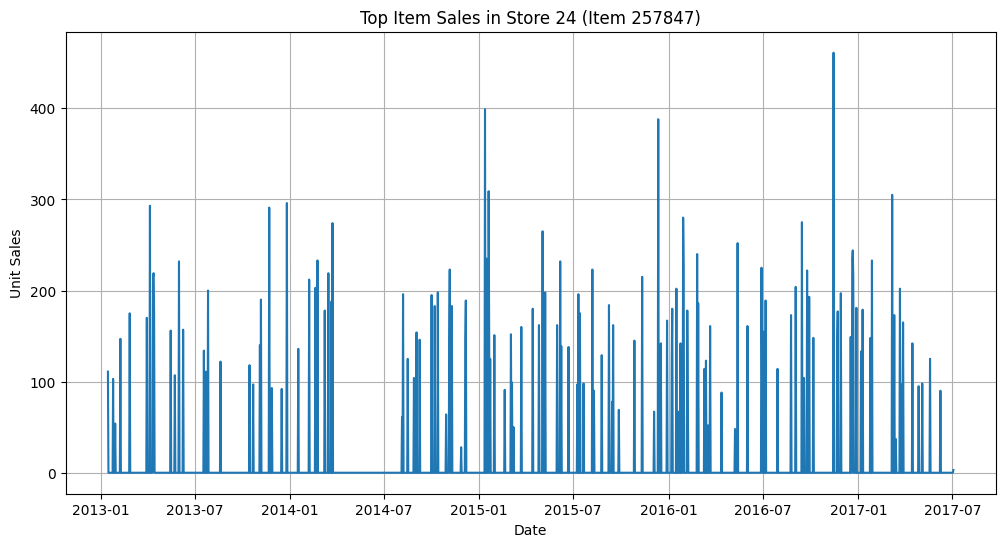

In [61]:
# 🔍 2. Zweitbester Store
store_id = top_stores[1]
top_item = (
    df_filled[df_filled['store_nbr'] == store_id]
    .groupby('item_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

sample = df_filled[(df_filled['store_nbr'] == store_id) & (df_filled['item_nbr'] == top_item)]

plt.figure(figsize=(12,6))
plt.plot(sample['date'], sample['unit_sales'])
plt.title(f"Top Item Sales in Store {store_id} (Item {top_item})")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.grid()
plt.show()

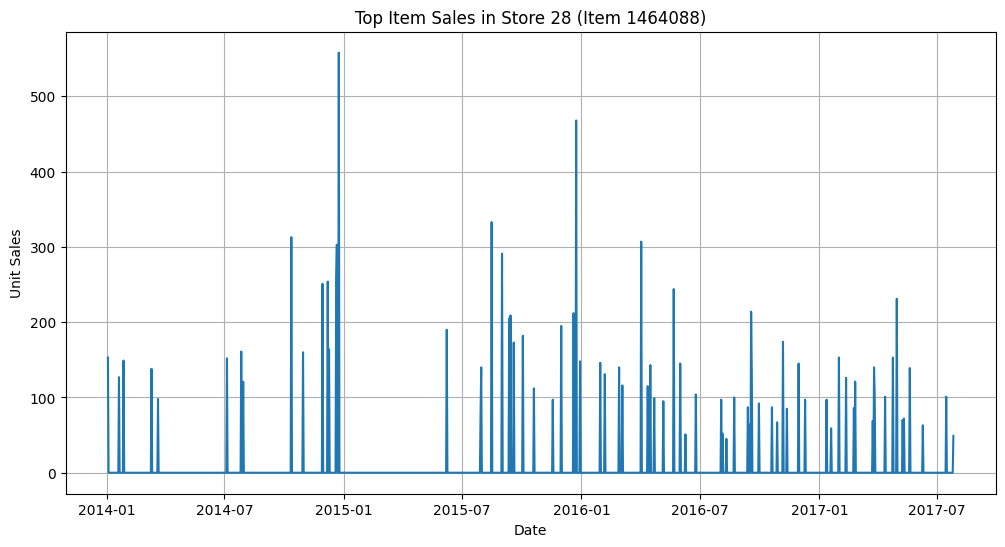

In [62]:
# 🔍 3. Drittbester Store
store_id = top_stores[2]
top_item = (
    df_filled[df_filled['store_nbr'] == store_id]
    .groupby('item_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

sample = df_filled[(df_filled['store_nbr'] == store_id) & (df_filled['item_nbr'] == top_item)]

plt.figure(figsize=(12,6))
plt.plot(sample['date'], sample['unit_sales'])
plt.title(f"Top Item Sales in Store {store_id} (Item {top_item})")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.grid()
plt.show()